## Neural Probabilitistic Language Model with Noise Contrastive Estimation

In [55]:
# =========================
# Neural Probabilistic Language Model 
# Bengio et al. (2003) 
# =========================

# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# 2. Config
n = 4        # context size = n-1 previous words + 1 target
m = 10       # embedding dimension [m x 1]
h = 16       # hidden layer dimension [h x 1]
epochs = 20
lr = 0.01


#### Toy dataset

In [56]:
# -----------------------------
# 3. Toy Corpus (~20 sentences)
# -----------------------------
corpus = [
    "the cat sat down",
    "the cat ate food",
    "the dog sat down",
    "the dog ate food",
    "a cat chased a mouse",
    "the dog chased the cat",
    "a dog barked loudly",
    "the cat meowed softly",
    "the bird sang sweetly",
    "a bird flew away",
    "the fish swam fast",
    "a fish jumped high",
    "the boy played ball",
    "the girl sang song",
    "a boy read book",
    "a girl wrote letter",
    "the sun shines bright",
    "the moon glows softly",
    "the stars twinkle bright",
    "a cat slept quietly"
]


# 4. Preprocessing
tokens = set(" ".join(corpus).split())
word2idx = {word: i for i, word in enumerate(sorted(tokens))}
idx2word = {i: word for word, i in word2idx.items()}
V = len(word2idx)   # vocabulary size |V|

# make context-target pairs for n-gram model
def make_ngrams(corpus, n):
    X, y = [], []
    for sentence in corpus:
        words = sentence.split()
        for i in range(len(words) - n):
            context = words[i:i+n]
            target = words[i+n]
            X.append([word2idx[w] for w in context])
            y.append(word2idx[target])
    return torch.tensor(X), torch.tensor(y)

X, y = make_ngrams(corpus, n-1)


print("Vocabulary size:", V)
print("Number of training samples:", len(X))
print('Example context:', X[0].tolist(), '-> target:', y[0].item())
print('Example context words:', [idx2word[i] for i in X[0].tolist()])
print('Example target word:', idx2word[y[0].item()])


Vocabulary size: 42
Number of training samples: 22
Example context: [39, 9, 30] -> target: 12
Example context words: ['the', 'cat', 'sat']
Example target word: down


In [57]:
import collections
counts = collections.Counter(" ".join(corpus).split())
total = sum(counts.values())
noise_dist = torch.tensor([counts[w]/total for w in tokens], dtype=torch.float)

#### Model architecture and data loader

In [58]:
# 5. Dataset/Dataloader
class NGramDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(NGramDataset(X, y), batch_size=4, shuffle=True)



In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class NPLM_NCE_ContextZ(nn.Module):
    def __init__(self, V, m, n, h, noise_dist, k):
        super().__init__()
        
        self.V = V
        self.m = m
        self.n = n
        self.h = h
        self.k = k
        self.noise_dist = noise_dist  # torch tensor of size [V]
        
        # --- Core NPLM parameters ---
        self.C = nn.Embedding(V, m)
        self.W = nn.Linear((n-1)*m, V, bias=False)
        self.H = nn.Linear((n-1)*m, h, bias=False)
        self.U = nn.Linear(h, V, bias=False)
        self.b = nn.Parameter(torch.zeros(V))
        self.d = nn.Parameter(torch.zeros(h))
        
        # --- Context-dependent log Z(x) layer ---
        # This predicts logZ from flattened context embedding
        self.Z_layer = nn.Linear((n-1)*m, 1, bias=True)
        
    def score(self, x):
        """Compute unnormalized log fθ(x, w)"""
        embeddings = self.C(x)                     # [batch, n-1, m]
        x_flat = embeddings.view(embeddings.size(0), -1)  # [batch, (n-1)*m]
        h_tanh = torch.tanh(self.d + self.H(x_flat))      # [batch, h]
        y = self.b + self.W(x_flat) + self.U(h_tanh)      # [batch, V]
        return y, x_flat
    
    def forward(self, context, target):
        """
        context: [batch, n-1]
        target:  [batch]
        """
        batch_size = context.size(0)
        logits, x_flat = self.score(context)  # [batch, V], [batch, (n-1)*m]
        
        # Predict log Z(x) for each context
        logZ = self.Z_layer(x_flat).squeeze(1)  # [batch]
        
        # Positive samples
        pos_logits = logits.gather(1, target.view(-1, 1)).squeeze(1)  # [batch]
        
        # Negative samples
        noise_samples = torch.multinomial(
            self.noise_dist, batch_size * self.k, replacement=True
        ).view(batch_size, self.k)
        noise_logits = logits.gather(1, noise_samples)  # [batch, k]
        
        # log(k * Pn(w))
        log_kPn_pos = torch.log(self.k * self.noise_dist[target])
        log_kPn_neg = torch.log(self.k * self.noise_dist[noise_samples])
        
        # Adjusted scores with context-dependent normalization
        pos_score = pos_logits - logZ - log_kPn_pos
        neg_score = noise_logits - logZ.unsqueeze(1) - log_kPn_neg
        
        # NCE loss
        pos_loss = F.logsigmoid(pos_score)
        neg_loss = torch.sum(F.logsigmoid(-neg_score), dim=1)
        
        loss = - (pos_loss + neg_loss).mean()
        return loss, logZ.detach()
    
  


#### Training loop

Epoch 1 | Loss: 7.1643
Epoch 2 | Loss: 5.4473
Epoch 3 | Loss: 2.7046
Epoch 4 | Loss: 1.7259
Epoch 5 | Loss: 2.9943
Epoch 6 | Loss: 2.4481
Epoch 7 | Loss: 0.8776
Epoch 8 | Loss: 1.2147
Epoch 9 | Loss: 0.8673
Epoch 10 | Loss: 0.8227
Epoch 11 | Loss: 1.4926
Epoch 12 | Loss: 1.5725
Epoch 13 | Loss: 0.6867
Epoch 14 | Loss: 0.4070
Epoch 15 | Loss: 0.5864
Epoch 16 | Loss: 0.4465
Epoch 17 | Loss: 0.3851
Epoch 18 | Loss: 0.2680
Epoch 19 | Loss: 0.4002
Epoch 20 | Loss: 0.7188


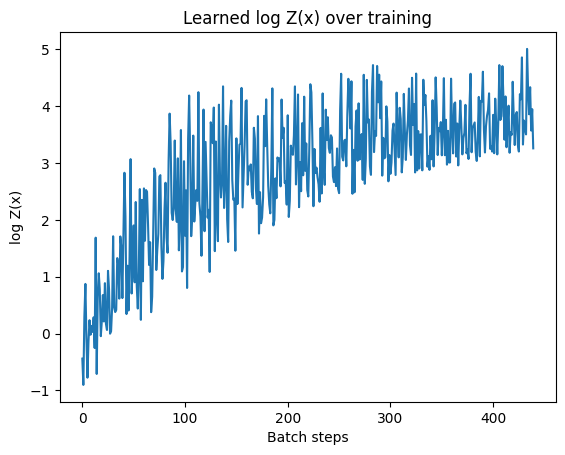

In [ ]:
import matplotlib.pyplot as plt

# Assuming corpus already tokenized and dataloader prepared
model = NPLM_NCE_ContextZ(V, m, n, h, noise_dist, k=5)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

logZ_history = []

for epoch in range(epochs):
    for context, target in train_loader:
        loss, logZ = model(context, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        logZ_history.extend(logZ.tolist())
    print(f"Epoch {epoch+1} | Loss: {loss.item():.4f}")




#### Probability of next word

In [61]:
# -----------------------------
# 6. Prediction Function
# -----------------------------

@torch.no_grad()
def predict_next(self, context, top_k=5):
    """
    Predict next word probabilities given context.
    context: [1, n-1] tensor of word indices
    """
    logits, x_flat = model.score(context)  # [1, V], [1, (n-1)*m]
    
    # Get learned logZ(x)
    logZ = model.Z_layer(x_flat).squeeze(1)  # scalar per batch
    
    # Get unnormalized log probabilities by subtracting learned logZ
    log_probs = logits - logZ.unsqueeze(1)
    # Convert to probabilities without re-normalizing (exp is monotonic, so ranking is preserved)
    probs = torch.exp(log_probs)
    
    # Top-k predictions
    top_probs, top_indices = probs.topk(top_k, dim=1)
    
    # Convert indices to words and return with probabilities
    predictions = [(idx2word[idx.item()], prob.item()) for idx, prob in zip(top_indices.squeeze(0), top_probs.squeeze(0))]
    return predictions

# Test a few predictions
test_contexts = [
    ["the", "cat", "sat"],
    ["a", "cat", "chased"],
    ["a","dog","barked"],
    ["the","stars","glows"]
]

for context in test_contexts:
    # Convert words to indices
    context_indices = torch.tensor([[word2idx[w] for w in context]])
    predictions = predict_next(model, context_indices)
    print(f"\nContext: {context}")
    for i, (word, prob) in enumerate(predictions, 1):
        print(f"  {i}. '{word}' ({prob:.4f})")


Context: ['the', 'cat', 'sat']
  1. 'down' (0.8185)
  2. 'sweetly' (0.0313)
  3. 'fast' (0.0166)
  4. 'softly' (0.0137)
  5. 'ball' (0.0112)

Context: ['a', 'cat', 'chased']
  1. 'a' (0.3696)
  2. 'letter' (0.0369)
  3. 'the' (0.0219)
  4. 'quietly' (0.0202)
  5. 'away' (0.0105)

Context: ['a', 'dog', 'barked']
  1. 'loudly' (0.5326)
  2. 'letter' (0.0493)
  3. 'book' (0.0316)
  4. 'high' (0.0310)
  5. 'song' (0.0276)

Context: ['the', 'stars', 'glows']
  1. 'sweetly' (0.0998)
  2. 'bright' (0.0516)
  3. 'fast' (0.0202)
  4. 'softly' (0.0170)
  5. 'ball' (0.0098)
